# Interpreting random forest

Notebook is based on [a kaggle demo](https://www.kaggle.com/edeastwood/titanic-random-forest-using-sklearn-and-pandas)

Goals:

- feature importance / feature interaction scores
- Different ways of decomposing the random forest
    - Connection map
    - Visualization of each tree
    - Frequent feature interactions
    - Individual explanation
- Use those tools to understand RF trained on the Titanic dataset

# Learning Titanic

In [117]:
import pandas
import numpy as np
import re
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline



## load data

In [44]:
TRAIN_PATH = "./train.csv"
TEST_PATH = "./test.csv"
train = pandas.read_csv(TRAIN_PATH)
test = pandas.read_csv(TEST_PATH)

## identify columns that have blank values

In [45]:
train.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

### age, embarked, fare and cabin all contain blank values: 
* age could depend on various features, we'll investigate these then use regression to fill in the blanks
* The majority of passengers embarked from Southampton. We'll just fill the small number of blanks with 'S'.
* First impressions are that fare doesn't seem particularly useful. It probably can't tell us much more than point of embarkation, class of travel and number of cabins/passengers.
* Cabin appears too sparsely populated to fill reliably.

## We simply drop Cabin and then drop rows that has NA's

In [75]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
388,389,0,3,"Sadlier, Mr. Matthew",male,NaN,0,0,367655,7.7292,NaN,Q
141,142,1,3,"Nysten, Miss. Anna Sofia",female,22.0,0,0,347081,7.7500,NaN,S
189,190,0,3,"Turcin, Mr. Stjepan",male,36.0,0,0,349247,7.8958,NaN,S
576,577,1,2,"Garside, Miss. Ethel",female,34.0,0,0,243880,13.0000,NaN,S
182,183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S


In [76]:
X = train.drop('Cabin', axis=1).dropna()
Y = np.array(X['Survived'])

In [77]:
X = X[['Age', 
              'Embarked', 
              'Sex', 
              'Parch', 
              'SibSp']]
X.sample(5)

,Age,Embarked,Sex,Parch,SibSp
534,30.0,S,female,0,0
281,28.0,S,male,0,0
649,23.0,S,female,0,0
148,36.5,S,male,2,0
728,25.0,S,male,0,1


In [78]:
# label encode string features
categorical_names = {}
categorical_features = ['Embarked', 'Sex']
for feature in categorical_features:
    le = preprocessing.LabelEncoder()
    le.fit(X[feature])
    X[feature] = le.transform(X[feature])
    categorical_names[feature] = le.classes_
X.sample(5)

,Age,Embarked,Sex,Parch,SibSp
13,39.0,2,1,5,1
550,17.0,0,1,2,0
720,6.0,2,0,1,0
363,35.0,2,1,0,0
349,42.0,2,1,0,0


In [79]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = .3)

In [80]:
rf = RandomForestClassifier()
rf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

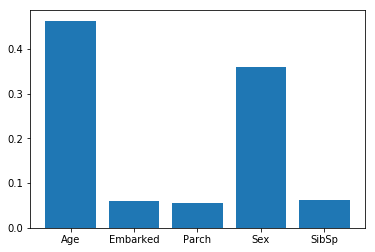

In [119]:
plt.bar(X.columns, rf.feature_importances_)
plt.show()

### Find frequent interactions in RF
https://github.com/Yu-Group/iterative-Random-Forest

In [88]:
from sklearn.tree import export_graphviz
import pydotplus 

In [120]:
from irf.irf_jupyter_utils import draw_tree

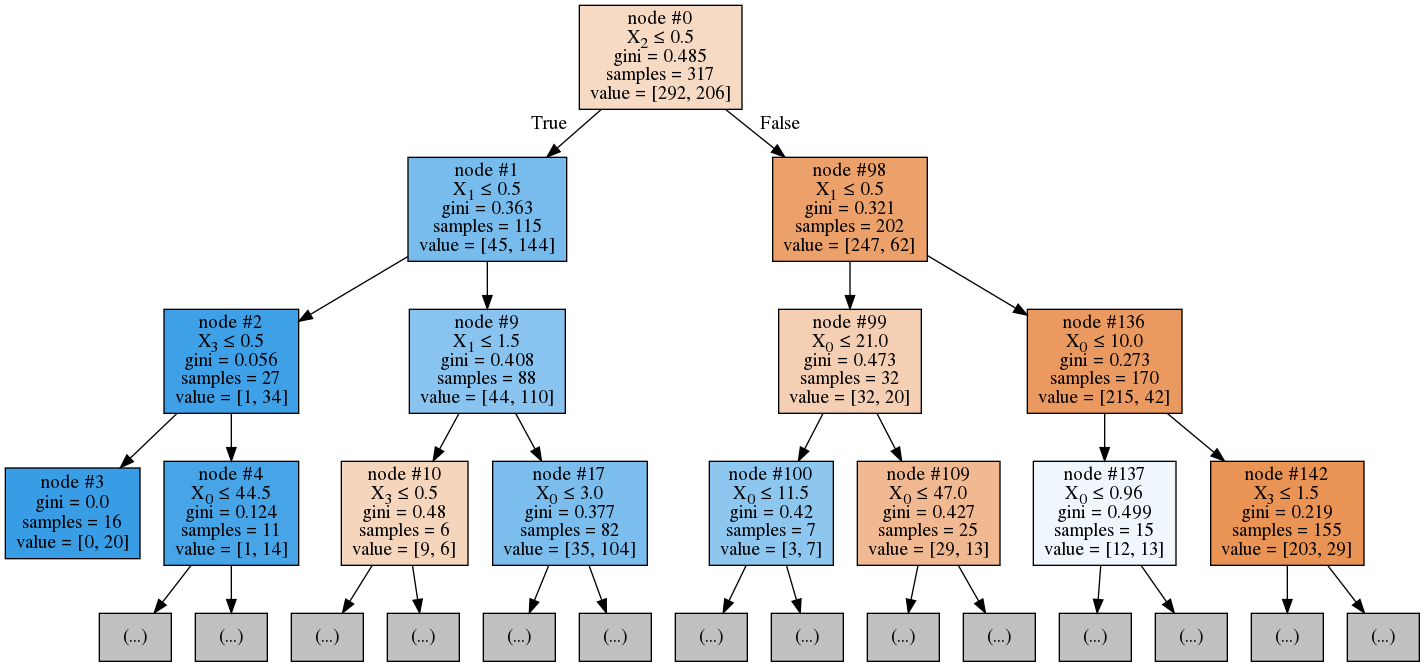

In [121]:
draw_tree(rf.estimators_[0], max_depth=3)

In [96]:
X.columns

Index(['Age', 'Embarked', 'Sex', 'Parch', 'SibSp'], dtype='object')

In [100]:
from irf import irf_utils

In [102]:
all_rf_tree_data = irf_utils.get_rf_tree_data(
    rf=rf, X_train=Xtrain, X_test=Xtest, y_test=Ytest)

In [103]:
np.random.seed(12)
all_rit_tree_data = irf_utils.get_rit_tree_data(
    all_rf_tree_data=all_rf_tree_data,
    bin_class_type=1,
    M=100,
    max_depth=2,
    noisy_split=False,
    num_splits=2)

In [105]:
print("Feature ranking:")

feature_importances_rank_idx = all_rf_tree_data['feature_importances_rank_idx']
feature_importances = all_rf_tree_data['feature_importances']

for f in range(Xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1
                                   , feature_importances_rank_idx[f]
                                   , feature_importances[feature_importances_rank_idx[f]]))

Feature ranking:
1. feature 0 (0.463028)
2. feature 2 (0.358430)
3. feature 4 (0.061985)
4. feature 1 (0.060639)
5. feature 3 (0.055919)


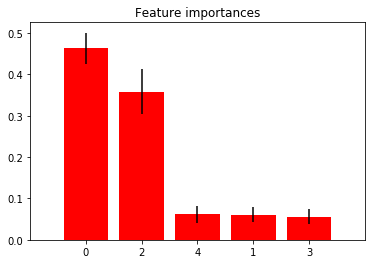

In [122]:
# Plot the feature importances of the forest
feature_importances_std = all_rf_tree_data['feature_importances_std']

plt.title("Feature importances")
plt.bar(range(Xtrain.shape[1])
        , feature_importances[feature_importances_rank_idx]
        , color="r"
        , yerr = feature_importances_std[feature_importances_rank_idx], align="center")
plt.xticks(range(Xtrain.shape[1]), feature_importances_rank_idx)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [111]:
all_rf_weights, all_K_iter_rf_data, \
all_rf_bootstrap_output, all_rit_bootstrap_output, \
stability_score = irf_utils.run_iRF(X_train=Xtrain,
                                    X_test=Xtest,
                                    y_train=Ytrain,
                                    y_test=Ytest,
                                    K=1,
                                    n_estimators=20,
                                    B=30,
                                    random_state_classifier=2018,
                                    propn_n_samples=.2,
                                    bin_class_type=1,
                                    M=20,
                                    max_depth=5,
                                    noisy_split=False,
                                    num_splits=2,
                                    n_estimators_bootstrap=5)

In [112]:
stability_score

{'0': 0.6666666666666666,
 '0_1': 0.13333333333333333,
 '0_1_2': 0.8666666666666667,
 '0_1_2_3': 0.4,
 '0_1_2_3_4': 0.16666666666666666,
 '0_1_2_4': 0.6666666666666666,
 '0_1_4': 0.03333333333333333,
 '0_2': 1.0,
 '0_2_3': 0.8666666666666667,
 '0_2_3_4': 0.6,
 '0_2_4': 0.9666666666666667,
 '0_3': 0.23333333333333334,
 '0_3_4': 0.03333333333333333,
 '0_4': 0.13333333333333333,
 '1_2': 0.16666666666666666,
 '1_2_3': 0.03333333333333333,
 '2': 0.5,
 '2_3': 0.13333333333333333,
 '2_3_4': 0.06666666666666667,
 '2_4': 0.1,
 '3': 0.06666666666666667}

In [113]:
from irf import irf_jupyter_utils

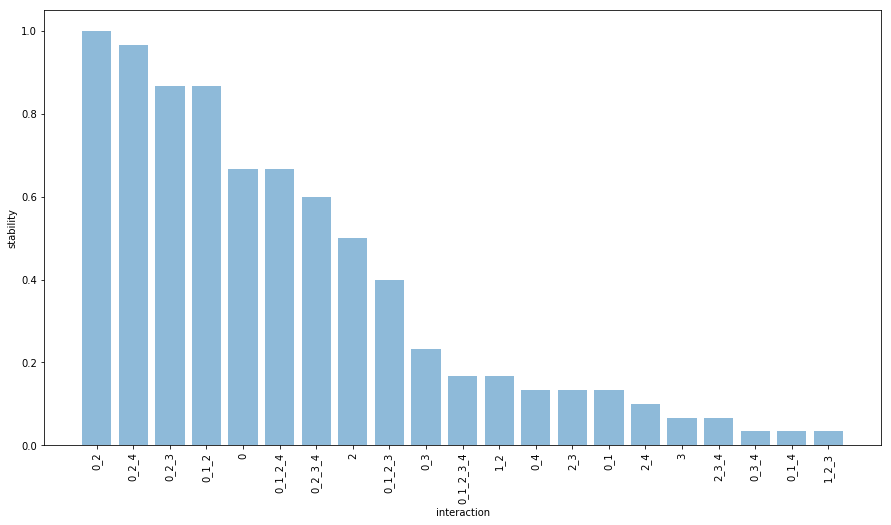

In [118]:
irf_jupyter_utils._get_histogram(stability_score, sort = True)